In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sn

import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [7]:
from google.colab import files
uploaded = files.upload()


Saving csvTrainImages 13440x1024.csv to csvTrainImages 13440x1024.csv


In [8]:
x_train = pd.read_csv("csvTrainImages 13440x1024.csv",header=None).to_numpy()

In [10]:
from google.colab import files
uploaded = files.upload()

Saving csvTestLabel 3360x1.csv to csvTestLabel 3360x1.csv
Saving csvTrainLabel 13440x1.csv to csvTrainLabel 13440x1.csv
Saving csvTestImages 3360x1024.csv to csvTestImages 3360x1024.csv


In [11]:

y_train = pd.read_csv("csvTrainLabel 13440x1.csv",header=None).to_numpy()-1 
x_test = pd.read_csv("csvTestImages 3360x1024.csv",header=None).to_numpy()
y_test = pd.read_csv("csvTestLabel 3360x1.csv",header=None).to_numpy()-1

print("x_train.shape =", x_train.shape, "\ny_train.shape =", y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


(13440, 32, 32, 1) (3360, 32, 32, 1)


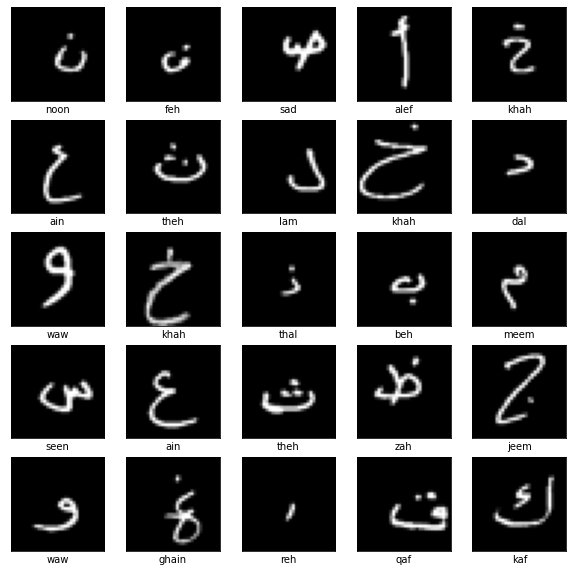

In [12]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

ra = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(32,32).T,"gray")
    plt.xlabel(arabic_characters[int(y_train[ra[i]][0])])
plt.show()

In [13]:
# Converting the class vector in integers to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape, y_test.shape)
for i in zip(y_train[0], arabic_characters):
    print(i)

(13440, 28) (3360, 28)
(1.0, 'alef')
(0.0, 'beh')
(0.0, 'teh')
(0.0, 'theh')
(0.0, 'jeem')
(0.0, 'hah')
(0.0, 'khah')
(0.0, 'dal')
(0.0, 'thal')
(0.0, 'reh')
(0.0, 'zain')
(0.0, 'seen')
(0.0, 'sheen')
(0.0, 'sad')
(0.0, 'dad')
(0.0, 'tah')
(0.0, 'zah')
(0.0, 'ain')
(0.0, 'ghain')
(0.0, 'feh')
(0.0, 'qaf')
(0.0, 'kaf')
(0.0, 'lam')
(0.0, 'meem')
(0.0, 'noon')
(0.0, 'heh')
(0.0, 'waw')
(0.0, 'yeh')


In [14]:
def get_model():
    In = Input(shape=(32,32,1))
    x = Conv2D(32, (5,5), padding="same", activation="relu")(In)
    x = Conv2D(32, (5,5), activation="relu")(x)
    x = Conv2D(32, (5,5), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = Conv2D(64, (5,5), activation="relu")(x)
    x = Conv2D(64, (5,5), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    
    Out = Dense(28, activation="softmax")(x)
    
    model = Model(In, Out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model = get_model()
#keras.utils.vis_utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [16]:
batch_size = 64
epochs = 20

train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(x_test, y_test, batch_size=batch_size)

In [19]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="best.hdf5",#сохранение модели
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')


history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = x_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = x_test.shape[0] // batch_size
                              )

Epoch 1/20
  4/210 [..............................] - ETA: 4s - loss: 0.0706 - accuracy: 0.9766

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


210/210 [==============================] - 6s 27ms/step - loss: 0.1115 - accuracy: 0.9677 - val_loss: 0.1506 - val_accuracy: 0.9573
Epoch 2/20
210/210 [==============================] - 6s 27ms/step - loss: 0.1121 - accuracy: 0.9662 - val_loss: 0.1729 - val_accuracy: 0.9561
Epoch 3/20
210/210 [==============================] - 6s 27ms/step - loss: 0.1102 - accuracy: 0.9682 - val_loss: 0.1606 - val_accuracy: 0.9576
Epoch 4/20
210/210 [==============================] - 6s 27ms/step - loss: 0.1033 - accuracy: 0.9710 - val_loss: 0.1483 - val_accuracy: 0.9594
Epoch 5/20
210/210 [==============================] - 6s 27ms/step - loss: 0.1052 - accuracy: 0.9699 - val_loss: 0.1759 - val_accuracy: 0.9489
Epoch 6/20
210/210 [==============================] - 6s 27ms/step - loss: 0.1103 - accuracy: 0.9679 - val_loss: 0.1549 - val_accuracy: 0.9582
Epoch 7/20
210/210 [==============================] - 6s 27ms/step - loss: 0.0972 - accuracy: 0.9712 - val_loss: 0.1272 - val_accuracy: 0.9651
Epoch 8/20

In [28]:
model.save('my_model.h5')#сохранение модели
save_model= keras.models.load_model('my_model.h5')

#добавление слоя
inputs = keras.Input(shape=(32,32,1))
x = save_model(inputs, training=False)
x =  Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
new_model = keras.Model(inputs, outputs)



In [ ]:
model = keras.models.load_model('my_model.h5'
model.fit(new_x_train, new_y_train, batch_size=64,
                    epochs=3,
                    validation_data=(x_new_val, y_new_val)))# обучить на новых данных